In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb

Populating the interactive namespace from numpy and matplotlib


In [2]:
import group_data as gd
swarm = gd.GMR22H05_swarm
fly = swarm.flies[4]

In [3]:
import group_data as gd
registration_dir = '/media/FlyDataC/FlyDB/Fly%04d/'%(gd.segmented_fly)
import h5py
flattened_file = h5py.File(registration_dir + 'flatened_model.hdf5','a')

In [4]:
import muscle_model as mm
#confocal_model = mm.GeometricModel(filepath = '../imaging_post_processing/model_data.cpkl')
#confocal_view = mm.ModelViewMPL(confocal_model)
confocal_model = mm.GeometricModel(filepath = gd.muscle_anatomy_dir + 'confocal_outline_model.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)
import cv2
import cPickle
pkname = fly.fly_path + '/basis_fits.cpkl'
fly_frame = mm.Frame();fly_frame.load(pkname)

def get_line_database(line_name):
    #print line_name
    import cPickle
    f = open('../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    return line_database

def get_muscle_list(line_name):
    line_database = get_line_database(line_name)
    muscle_names = list()
    for key in line_database[line_name].keys():
        if line_database[line_name][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    muscles = [m for m in muscle_names if not('DVM' in m) and not('DLM' in m) and not('ps' in m)]
    return muscles

def frmt_axis(r,c,row,col):
    plb.gca().spines['top'].set_visible(False)
    plb.gca().spines['right'].set_visible(False)
    plb.gca().spines['left'].set_visible(False)
    plb.gca().spines['bottom'].set_visible(False)
    plb.gca().set_ybound(-0.1,1.8)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    if (c == 0):
        plb.gca().spines['left'].set_visible(True)
        plb.gca().set_ylabel(row)
    if (r == len(plot_sigs)-1):
        plb.gca().spines['bottom'].set_visible(True)
        [x.set_visible(True) for x in plb.gca().get_xticklabels()]
        [x.set_visible(True) for x in plb.gca().get_xticklines()[::2]]
    if (r == 0):
        pass
        #plb.gca().set_title(col)
    if ('amp' in row):
        plb.gca().set_ybound(-90,90)
    if ('freq' in row):
        plb.gca().set_ybound(0,250)
    if ('stripe' in row):
        plb.gca().set_ybound(0,2*pi)
        
    plb.gca().set_xbound(10,90)

def kill_spines():
    plb.gca().spines['top'].set_visible(False)
    plb.gca().spines['right'].set_visible(False)
    plb.gca().spines['left'].set_visible(False)
    plb.gca().spines['bottom'].set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    plb.gca().set_ybound(275,1024)
    plb.gca().set_xbound(0,800)
    
def warp_fly_image(fly_path,img,s = 1):
    A = confocal_model.frame.get_transform(fly_frame)
    Ap = np.dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    output_shape = (output_shape[0],output_shape[1])
    X_warped = cv2.warpAffine(img.T,Ap[:-1,:],output_shape)
    return X_warped

def get_model():
    model = [np.array(flattened_file[key]) for key in muscle_sigs['muscles']]
    model = transpose(model,(1,0,2))
    return model

In [5]:
#open the fly data
import muscle_model as mm
fly = gd.swarms['GMR22H05'].flies[11]
fly.open_fly_record()
imgs = fly.fly_record['experiments'].values()[0]['tiff_data']['images']
baseline_rng = fly.get_pkl_data('epoch_data.cpkl')['baseline_F']
bsline_img = np.mean(imgs[baseline_rng[0]:baseline_rng[1]],axis = 0)
muscle_sigs = fly.get_pkl_data('nnls_fits_bk_sub_F.cpkl')
axon_sigs = fly.fly_record['experiments'].values()[0]['tiff_data']['axon_framebase']
bsline_img_warped = mm.warp_fly_img(fly,bsline_img)
global_times = np.array(axon_sigs['times'])

In [6]:
roi_size = 60
i1_roi_ur = [260,660]
i1_roi_x = [i1_roi_ur[0],i1_roi_ur[0]+roi_size] #anterior roi x
i1_roi_y = [i1_roi_ur[1],i1_roi_ur[1]+roi_size] #anterior roi y

b2_roi_ur = [180,580]
b2_roi_x = [b2_roi_ur[0],b2_roi_ur[0]+roi_size] #anterior roi x
b2_roi_y = [b2_roi_ur[1],b2_roi_ur[1]+roi_size] #anterior roi y

In [6]:
#extract the roi_data -- takes a long time to run
plt_rng = slice(0,5600)
i1_list = list()
b2_list = list()
## run an analysis using standard roi's
for i in range(plt_rng.start,plt_rng.stop-1):
    print i
    wimg = mm.warp_fly_img(fly,imgs[i]-bsline_img)
    i1_list.append(np.mean(wimg[i1_roi_y[0]:i1_roi_y[1],i1_roi_x[0]:i1_roi_x[1]]))
    b2_list.append(np.mean(wimg[b2_roi_y[0]:b2_roi_y[1],b2_roi_x[0]:b2_roi_x[1]]))
# save the roi data
f = open('roi_data.cpkl','wb')
import cPickle
cPickle.dump({'i1':np.array(i1_list),'b2':np.array(b2_list)},f)
f.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


KeyboardInterrupt: 

In [7]:
# load the roi data
f = open('roi_data.cpkl','rb')
import cPickle
roi_dict = cPickle.load(f)

In [8]:
# convenience array variables
i1_roi_data = roi_dict['i1']
b2_roi_data = roi_dict['b2']#np.array(i1_list)
#b2_roi_data = np.array(b2_list)
i1_sig_data = muscle_sigs['fits'][muscle_sigs['muscles'].index('i1')]
b2_sig_data = muscle_sigs['fits'][muscle_sigs['muscles'].index('b2')]
i2_sig_data = muscle_sigs['fits'][muscle_sigs['muscles'].index('i2')]
hg4_sig_data = muscle_sigs['fits'][muscle_sigs['muscles'].index('hg4')]
iii3_sig_data = muscle_sigs['fits'][muscle_sigs['muscles'].index('iii3')]

In [9]:
# crop the time signal to the length of the roi data
roi_times = global_times[:5600-1]

/home/psilentp/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in power


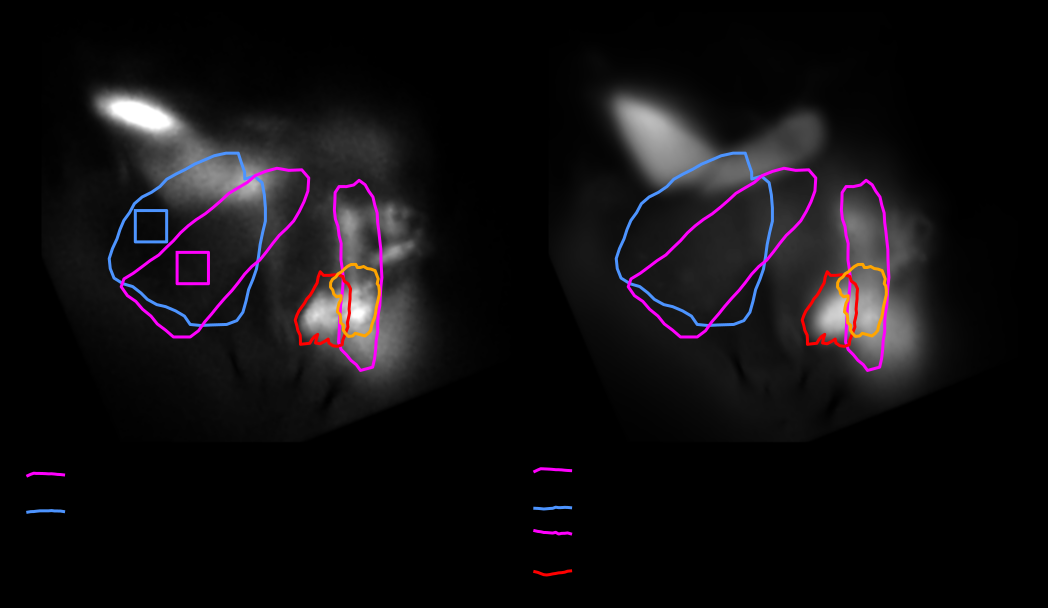

In [12]:
#################################################
## Make an example movie of a long segment at the beginning of the trial
## played back at normal speed
#################################################
# start a bit before 100.188 for example epoch

### Color settings
light_purple = '#ff00fe'
light_blue = '#4d94ff'
gamma = lambda x: x**1.9 # gamma adjustment
vmax = gamma(65) # maximum level
### Colors for the muscle outlines
contour_kwargs = {'b2':{'edgecolor': light_blue, 'linewidth': 3.0,'facecolor': 'none','alpha':1.0},
                 'i1':{'edgecolor': light_purple, 'linewidth': 3.0,'facecolor': 'none','alpha':1.0},
                 'i2':{'edgecolor': light_purple,'linewidth': 3.0,'facecolor': 'none','alpha':1.0},
                 'iii3':{'edgecolor': 'red', 'linewidth': 3.0,'facecolor': 'none','alpha':1.0},
                 'hg4':{'edgecolor': 'orange', 'linewidth': 3.0,'facecolor': 'none','alpha':1.0}}

### Switches to plot the muscle outlines on the movies
plot_muscle_anat = True
plot_roi_boxes = True

### Switch to just plot slowmo epoch
plot_focus_epoch = True

### Quite mode
quite_mode = True

img_idx = 1000
import numpy as np
w = 14
h = 8
aspect = w/float(h)

### construct the figure and get rid of the borders
fig = plb.figure(figsize = (w,h),facecolor='black')
fig.subplots_adjust(bottom = 0)
fig.subplots_adjust(top = 1)
fig.subplots_adjust(right = 1)
fig.subplots_adjust(left = 0)

### make the background black
from matplotlib.gridspec import GridSpec
gs = GridSpec(h*2,w*2)
bk_pannel = fig.add_subplot(gs[:,:])
bk_pannel.patch.set_facecolor('black')
data_pannel = fig.add_subplot(gs[:12,:14])
kill_spines()

#vmax = gamma(80)

#data_plot = plb.subplot(gs[:len(plot_sigs)/2,:4])
data_img = gamma(imgs[img_idx])
data_img = mm.warp_fly_img(fly,data_img)
data_img_handle = plb.imshow(data_img,cmap = plb.cm.gray,vmin = 0,vmax = vmax)

#figure(figsize = (10,10))
model = get_model()
confocal_model = mm.GeometricModel(filepath = gd.muscle_anatomy_dir + 'confocal_outline_model.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)

if plot_roi_boxes:
    plot([i1_roi_x[0],i1_roi_x[1],i1_roi_x[1],i1_roi_x[0],i1_roi_x[0]],
         [i1_roi_y[0],i1_roi_y[0],i1_roi_y[1],i1_roi_y[1],i1_roi_y[0]],color = light_purple,linewidth = 3.0,alpha = 1.0)
    plot([b2_roi_x[0],b2_roi_x[1],b2_roi_x[1],b2_roi_x[0],b2_roi_x[0]],
     [b2_roi_y[0],b2_roi_y[0],b2_roi_y[1],b2_roi_y[1],b2_roi_y[0]],color = light_blue,linewidth = 3.0,alpha = 1.0)


if plot_muscle_anat:
    confocal_view.plot(confocal_model.frame,contour_kwargs = contour_kwargs)

## add the pannel for the reconstructed model data
model_pannel = fig.add_subplot(gs[:12,14:])
#reconstruct the image stream
model_img = gamma(np.dot(muscle_sigs['fits'][:,:][:,img_idx],model)+bsline_img_warped)
model_img[isnan(model_img)] = 0
model_img_handle = plb.imshow(model_img,cmap = plb.cm.gray,vmin = 0,vmax = vmax)
kill_spines()
data_pannel.set_xbound(0,900)
data_pannel.set_ybound(200,1024)
model_pannel.set_xbound(0,900)
model_pannel.set_ybound(200,1024)

if plot_muscle_anat:
    confocal_view.plot(confocal_model.frame,contour_kwargs = contour_kwargs)

### add the signal panels
i1_roi_trace_pannel = fig.add_subplot(gs[12:13,:14],frameon = False)
i1_roi_trace_pannel.patch.set_facecolor(None)
i1_sig_trace_pannel = fig.add_subplot(gs[12:13,14:],frameon = False)
b2_roi_trace_pannel = fig.add_subplot(gs[13:14,:14],frameon = False)
b2_sig_trace_pannel = fig.add_subplot(gs[13:14,14:],frameon = False)
#b2_roi_trace_pannel = fig.add_subplot(gs[10:11,:10])
i2_sig_trace_pannel = fig.add_subplot(gs[14:15,14:],frameon = False)
#hg4_sig_trace_pannel = fig.add_subplot(gs[15:16,14:],frameon = False)
iii3_sig_trace_pannel = fig.add_subplot(gs[15:16,14:],frameon = False)


def calc_trace_data(trace,window_start = 20.0,current_time = 22.0):
    window_idx = argwhere((roi_times > window_start) & (roi_times < current_time))
    #print window_idx
    cropped_times = roi_times[window_idx]
    cropped_trace = trace[window_idx]
    return cropped_times,cropped_trace


if plot_focus_epoch:
    ###for slowmo trace 
    trace_window_s = 3.7
else:
    ### for normal speed
    trace_window_s = 10.0


current_time = 22.0
current_start = 20.0


sca(i1_roi_trace_pannel);kill_spines()
i1_roi_trace_handle = plot(*calc_trace_data(i1_roi_data,window_start = current_start,current_time = current_time),
                           color = light_purple,lw = 3.0)
i1_roi_trace_pannel.set_xbound(current_start,current_start+trace_window_s)
i1_roi_trace_pannel.set_ybound(min(i1_roi_data)-0.5,max(i1_roi_data))

sca(b2_roi_trace_pannel);kill_spines()
b2_roi_trace_handle = plot(*calc_trace_data(b2_roi_data,window_start = current_start,current_time = current_time),
                           color = light_blue,lw = 3.0)
b2_roi_trace_pannel.set_xbound(current_start,current_start+trace_window_s)
b2_roi_trace_pannel.set_ybound(min(b2_roi_data)-0.5,max(b2_roi_data))

########
########

sca(i1_sig_trace_pannel);kill_spines()
i1_sig_trace_handle = plot(*calc_trace_data(i1_sig_data,window_start = current_start,current_time = current_time),
                           color = light_purple,clip_on = False,lw = 3.0)
i1_sig_trace_pannel.set_xbound(current_start,current_start+trace_window_s)
i1_sig_trace_pannel.set_ybound(min(i1_sig_data)-0.5,max(i1_sig_data))

sca(b2_sig_trace_pannel);kill_spines()
b2_sig_trace_handle = plot(*calc_trace_data(b2_sig_data,window_start = current_start,current_time = current_time),
                           color = light_blue,clip_on = False,lw = 3.0)
b2_sig_trace_pannel.set_xbound(current_start,current_start+trace_window_s)
b2_sig_trace_pannel.set_ybound(min(b2_sig_data)-0.01,max(b2_sig_data)-0.2)

sca(i2_sig_trace_pannel);kill_spines()
i2_sig_trace_handle = plot(*calc_trace_data(i2_sig_data,window_start = current_start,current_time = current_time),
                           color = light_purple,clip_on = False,lw = 3.0)
i2_sig_trace_pannel.set_xbound(current_start,current_start+trace_window_s)
i2_sig_trace_pannel.set_ybound(min(i2_sig_data)-0.5,max(i2_sig_data))

#sca(hg4_sig_trace_pannel);kill_spines()
#hg4_sig_trace_handle = plot(*calc_trace_data(hg4_sig_data,window_start = window_start,current_time = current_time),
#                            color = 'orange',clip_on = False)
#hg4_sig_trace_pannel.set_xbound(window_start,window_start+trace_window_s)
#hg4_sig_trace_pannel.set_ybound(min(hg4_sig_data)-0.5,max(hg4_sig_data))

sca(iii3_sig_trace_pannel);kill_spines()
iii3_sig_trace_handle = plot(*calc_trace_data(iii3_sig_data,window_start = current_start,current_time = current_time),
                            color = 'red',clip_on = False,lw = 3.0)
iii3_sig_trace_pannel.set_xbound(current_start,current_start+trace_window_s)
iii3_sig_trace_pannel.set_ybound(min(iii3_sig_data)-0.5,max(iii3_sig_data))

time_chunks = np.array_split(roi_times,int(floor(roi_times[-1]/trace_window_s)))
chunk_starts = np.array([c[0] for c in time_chunks])

if plot_focus_epoch:
    #for focus epoch
    chunk_starts += 2.1

chunk_ends = np.array([c+trace_window_s for c in chunk_starts])

def update_pannels(t):
    chunk_idx = argwhere(t>=chunk_starts)[-1]
    current_start = chunk_starts[chunk_idx]
    current_end = chunk_ends[chunk_idx]
    img_idx = argwhere(t<roi_times)[0][0]
    i1_roi_trace_handle[0].set_data(*calc_trace_data(i1_roi_data,window_start = current_start,current_time = t))
    i1_roi_trace_pannel.set_xbound(current_start,current_start+trace_window_s)

    
    b2_roi_trace_handle[0].set_data(*calc_trace_data(b2_roi_data,window_start = current_start,current_time = t))
    b2_roi_trace_pannel.set_xbound(current_start,current_start+trace_window_s)
    
    
    ##########
    ##########
    
    i1_sig_trace_handle[0].set_data(*calc_trace_data(i1_sig_data,window_start = current_start,current_time = t))
    i1_sig_trace_pannel.set_xbound(current_start,current_start+trace_window_s)

    
    b2_sig_trace_handle[0].set_data(*calc_trace_data(b2_sig_data,window_start = current_start,current_time = t))
    b2_sig_trace_pannel.set_xbound(current_start,current_start+trace_window_s)

    i2_sig_trace_handle[0].set_data(*calc_trace_data(i2_sig_data,window_start = current_start,current_time = t))
    i2_sig_trace_pannel.set_xbound(current_start,current_start+trace_window_s)

    #hg4_sig_trace_handle[0].set_data(*calc_trace_data(hg4_sig_data,window_start = current_start,current_time = t))
    #hg4_sig_trace_pannel.set_xbound(current_start,current_start+trace_window_s)
    
    iii3_sig_trace_handle[0].set_data(*calc_trace_data(iii3_sig_data,window_start = current_start,current_time = t))
    iii3_sig_trace_pannel.set_xbound(current_start,current_start+trace_window_s)
    
    model_img = gamma(np.dot(muscle_sigs['fits'][:,:][:,img_idx],model)+bsline_img_warped)
    model_img[isnan(model_img)] = 0
    model_img_handle.set_data(model_img)
    
    data_img = gamma(imgs[img_idx])
    data_img = mm.warp_fly_img(fly,data_img)
    data_img_handle.set_data(data_img)
    draw()
    if not(quite_mode):
        print(t)
    #b2_trace_handle
    #i1_sig_trace_handle
    #b2_sig_trace_handle
    #i2_sig_trace_handle
    #hg4_sig_trace_handle

if plot_focus_epoch:
    #for focus window
    st = chunk_starts[25]
else:
    #for normal speed
    st = chunk_starts[0]+0.1

update_pannels(st)
#draw()

import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter 
Writer = FFMpegWriter 
writer = Writer(fps=30, metadata=dict(artist='Theodore Lindsay'), extra_args=['-vcodec', 'h264', '-pix_fmt','yuv420p'])

#for normal speed
if plot_focus_epoch:
    ani = animation.FuncAnimation(fig, update_pannels, frames=np.arange(st,st+trace_window_s,1/90.0), blit=False)
    ani.save('roi_model_comparison_focus_epoch.mp4', writer=writer)
else:
    ani = animation.FuncAnimation(fig, update_pannels, frames=np.arange(st,133,1/30.0), blit=False)
    ani.save('roi_model_comparison.mp4', writer=writer)

#savefig('roi_model_comparison.pdf')